# Heat Equation Solvers

##### Plan of Attack
1. Create Explicit solver algorithm and ensure accurate solutions [DONE]
2. Create variable for function with sympy compatibility (!Uneccessary!) [DONE - ELSEWHERE]
3. Create an implicit solver algorithm  [DONE]
4. Create Crank-Nicolson algorithm [DONE]
5. Add in fourier analysis [ISSUES]
6. Use library methods [HAVEN'T FOUND ANY, SO DONE]
7. Add in updating graph to show heat equation working ("video") [DONE]
8. 2D heat equation [TODO]
9. Clean up and refactor (use numpy matric manip for explicit), create standalong .py algorithms file [TODO]

##### Next Steps (for future notebooks)
1. 3D Heat Equation?
2. Expand to other (linear) wave/wavelike phenomenon
3. Expore nonlinear waves

-----

## 1-D Heat Equation (2nd Order PDE):
# $u_{t}$ = $\gamma$$u_{xx}$ =
# $\frac{\partial{u}}{\partial{t}}$ = $\gamma$$\frac{\partial^2{u}}{\partial{x}^2}$
#### where $\gamma$ = diffusion coefficient (also given as 'D')

## Section I: Create base equation and check

### Step 0: Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

import sympy as sp # Not needed but imported for potential future use

### Step 1: Define Variables

In [ ]:
# Givens:
D = 5 # diffusion constant (gamma above)
dx = .1 # Discrete x step
L = 3 # Length of 'rod'

# Derived:
dt = dx**2 / (2*D) # dt = .001, should be equal to or less than dx^2/(2*D) for non blowup requirements
mu = D * (dt/dx**2) # Necessary Coefficient
Nx = int(L/dx)

#Can also use your own dx:
# N = *choose an integer*
# dx = L/N

print('N = ',Nx)

### Step 2: Codify Initial Conditions

In [ ]:
# f(x) = u(t=0,x)
def f(x):
    return x * (x - 1) * (x - 3)

# Initialize Array
Ui = []

# Create holder for first row of array = the initial conditions
u_t_x_0 = []

# Populate holder with Initial Conditions, need N+2 to include both x = 0 and x = L = 3
for i in range(Nx+1):
    n = i * dx
    u_t_x_0.append(f(n))
Ui.append(u_t_x_0)
Ui

### Step 3: Iterate Using Heat Equation (diffusion equation)

# !-*[TODO] modify the numbers here such that all three methods have similar real time intevals.  for example modify t below such that component steps of overall solution can be directly compared to other methods*-!

In [ ]:
t = 1000 # Time steps to examine

# Run this loop the number of time steps you want to analyze ('_' is a placeholder for loop count)
for _ in range(t):

    # First, create empty time step - basically initize a list of u(t,x) to fill
    u_t_x = []
    # Now grab the last time step line (the value of u at each x for the previous t)
    u_line = Ui[-1]
    
    for i in range(1,Nx):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        u = u_line[i] + mu*(u_line[i+1] + u_line[i-1] - 2*u_line[i])
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,0)
    u_t_x.insert(len(u_line),0)

    # Now append the full solutions matrix
    Ui.append(u_t_x) 

In [ ]:
# Display Solutions as a dataframe (for personal convenience)
df = pd.DataFrame(Ui).round(3)
df

In [ ]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in np.arange(0,len(Ui),20):
    plt.plot(Ui[i])
    plt.xlabel('x')
    plt.ylabel('T')
    plt.text(0,-1.75,"Lines represent time values")
plt.show()

In [ ]:
def heat_plotter(U, steps):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('x')  # Set x-axis label
    ax.set_ylabel('T')  # Set y-axis label

    # Set the y-axis limits
    y_min = min([min(u) for u in U]) - 0.5  # Find the minimum y-value in U with some buffer
    y_max = max([max(u) for u in U]) + 0.5  # Find the maximum y-value in U with some buffer
    ax.set_ylim(y_min, y_max)

    lines = []  # List to store line objects
    alpha_decay = .5  # Factor to reduce the alpha of previous lines

    plt.show()

    for i in np.arange(0, len(U), len(U)//steps):
        # Update the alpha values of existing lines
        for line in lines:
            line.set_alpha(line.get_alpha() * alpha_decay)

        # Add new line
        new_line, = ax.plot(U[i], color='red', alpha=1.0)  # Start with full opacity
        lines.append(new_line)  # Store the new line object
        ax.set_title(f"Plot at time = {i/(len(U)-1)}s")  # Update the title with the current step

        # Handling plot display
        clear_output(wait=True)  # Clear the previous plot
        display(fig)  # Display the current figure

        time.sleep(0.25)  # Pause for half a second before the next update

In [ ]:
heat_plotter(Ui,20)

### Step 4: Create function

In [ ]:
def heat_1d(f_u_0_x, D, dx, L, f_u_t_0, f_u_t_L, t_max, dt_mod=1):
    '''
    This function takes in an initial temperature distribution, along with boundary conditions,
    and emits the changes to the temperature distribution based on finite difference analysis.
    
    NOTE 1: This function is NOT optimized for numpy use in Python.  It works well for simple problems, but
    needs to be updated to use Numpy arrays for large datasets.
    
    Parameters:    
    f = the function governing the initial heat condition in the rod, must be a def f() [function]
    D = Heat diffusion constant (aka gamma) [float]
    dx = distance between analysis nodes [float]
    L = length of rod [float]
    u_t_0 = Boundary condition at zero [float]
    u_t_L = Boundary Condition at L [float]
    t_max = max time [integer or float]
    dt_mod = (optional) alter this to change then impact of the time interval in caase solutions are unstable
    
    Returns:
    U = array containing the temperature distributions across length L at time step t=0 to t=t_max
    '''
    
    # First set the time step such that dt </= dx**2/(2*D); this determines mu:
    dt = dx**2 / (2*D) # dt = .001, should be equal to or less than dx^2/(2*D) for stability requirements
    mu = D * (dt/dx**2) * dt_mod # Related to dt above, must be </= to .5
    
    # Generate x nodes across rod:
    Nx = int(L/dx)
    
    # Initialize Array:
    U = []

    # Create holder for first row of array = the initial temperature distribution:
    u_t_x_0 = []

    # Populate holder with initial distribution, need N+1 to include x = 3
    for i in range(Nx+1):
        # Normalize the step
        n = i*dx
        
        # Solve the initial value equation for each node:
        # This try/except statement is put in in case the initial condition is a constant:
        try:
            f_n = f_u_0_x(n)
        except:
            f_n = f_u_0_x
            
        u_t_x_0.append(f_n)
    
    # Replace initial distribution boundary conditions with, well, boundary conditions
    try:
        u_t_x_0[0] = f_u_t_0(0)
    except:
        u_t_x_0[0] = f_u_t_0
            
    try:
        u_t_x_0[-1] = f_u_t_L(0)
    except:
        u_t_x_0[-1] = f_u_t_L
    
    # Add this first row to the Array to return
    U.append(u_t_x_0)

    # Run this loop the number of time steps you want to analyze (note: '_' is a placeholder for loop count)
    for t in range(t_max):

        # First, create empty time step - basically initize an empty list to fill with u(t,x) :
        u_t_x = []
        
        # Now grab the previous time step distribution (the value of u at each x for the previous t):
        u_line = U[-1]

        # Now loop through all 'inner' values, that is 0 < x < L, requiring a range of 1 to N:
        for i in range(1,Nx):
            # Using a modified equation 5.14 to calculate u at each x value:
            u = u_line[i] + mu*(u_line[i+1] + u_line[i-1] - 2*u_line[i])
            # Append this value to the time step line:
            u_t_x.append(u)

        # Append the first and last values with the boundary conditions.  Use try and except in case constant
        try:
            a = f_u_t_0(t)
        except:
            a = f_u_t_0
            
        try:
            b = f_u_t_L(t)
        except:
            b = f_u_t_L
        
        u_t_x.insert(0,a)
        u_t_x.insert(len(u_line),b)

        # Now append the full solutions matrix with time step distribution:
        U.append(u_t_x) 

    return U

Example of using the function with a boundary condition that is itself a function:

In [ ]:
f = 20 # Function is constant
D = 4.25e-6
dx = .0001
L = .01
u_t_0 = 50
#u_t_L = 0  ! - Commented this out since we are replacing it with the function below

def u_t_L(t):
    return t/10

t_max = 1000

U = heat_1d(f, D, dx, L, u_t_0, u_t_L, t_max)

In [ ]:
df = pd.DataFrame(U).round(2)
df

In [ ]:
plt.figure(figsize = (12,12))
for i in np.arange(0,1000,50):
    plt.plot(U[i], label = f't = {round(i*dt,2)}s')
plt.legend()
plt.xlabel('x')
plt.ylabel('T')
plt.text(20,80,'Left boundary = 50 (constant); Right boundary = t/100')
plt.text(20,76,'Initial conditions = 20 (constant)')
plt.show()

In [ ]:
heat_plotter(U,20)

#### Additional Example - Has different initial condition regimes:

In [ ]:
def f3(x):
    if x < (1/3):
        return 2*abs(x-(1/6))-(1/3)
    elif x < (2/3):
        return 0
    else:
        return (1/2)-3*abs(x-(5/6))
    
D = 1
dx = .05
L = 1
u_t_0 = 0
u_t_L = 0
t_max = 1000

U3 = heat_1d(f3, D, dx, L, u_t_0, u_t_L, t_max, dt_mod=1)

In [ ]:
df = pd.DataFrame(U3).round(2)
df

In [ ]:
for i in [0,10,100,400, 1000]:
    plt.plot(U3[i], label = f't = {round(i*dt,2)}s')
plt.legend()
plt.show()

In [ ]:
heat_plotter(U3,20)

## Section II: Implicit Method

In [ ]:
# Boundary Condition Functions (Direchelet - time domain)

def u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''
    return 0

def u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

In [ ]:
# Initial Condition Functions

def u_0_x(x):
    '''
    Assigns the initial values for u (non-boundary points).
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return x * (x - 1) * (x - 3)

In [ ]:
# Assign length
L = 3
t_max = 5

# Grid spacing
dx = .1
dt = .1 # !-Note: For explicit needs to be less than dt**2/(2*D), implicit has no such restrictions for stability

# Number of dx nodes, including 0 node
Nx = int(L/dx) + 1

# Discretize x and t
x = np.arange(0,L+dx,dx)
t = np.arange(0,t_max+dt,dt)

# Create return array (n x m matrix)
n = len(x)
m = len(t)
T = np.zeros((m,n))

In [ ]:
# Set boundary values
T[:,0] = u_t_0(0)
T[:,-1] = u_t_L(0)

In [ ]:
# Derive the Lambda, as lambo, because lambos are FAAAAAST
lambo = D * dt/dx**2

In [ ]:
# LHS = A: a tridiagnonal matrix
A = np.diag([1+2*lambo]*(Nx-2)) + np.diag([-lambo]*(Nx-3),1) + np.diag([-lambo]*(Nx-3),-1)
len(A[0])

In [ ]:
# Boundary Condition RHS

In [ ]:
for i in range(0,n-1):
    b = T[i,1:-1].copy() #Need the copy here!
    b[0] = b[0] + lambo*T[i+1,0]
    b[-1] = b[-1] + lambo*T[i+1,-1]
    sol = np.linalg.solve(A,b)
    T[i+1,1:-1] = sol

In [ ]:
pd.DataFrame(T)

In [ ]:
for i in np.arange(0,len(T)):
    plt.plot(T[i])
plt.show()

In [ ]:
heat_plotter(T,20)

##### Compare with Ui with 1000 time steps

In [ ]:
len(Ui)

In [ ]:
for i in np.arange(0,len(Ui),1000//31):
    plt.plot(Ui[i])
plt.show()

## Section III: Crank-Nicholson Method

In [ ]:
# Assign length
L = 3

# Grid spacing
dx = .1
dt = .1 # !-Note: For explicit needs to be less than dt**2/(2*D), implicit has no such restrictions for stability

# Number of dx nodes, including 0 node
Nx = int(L/dx) + 1

# Discretize x and t
x = np.arange(0,L+dx,dx)
t = np.arange(0,L+dt,dt)

# Create return array (n x m matrix)
n = len(x)
m = len(t)
Tcr = np.zeros((n,m))

# Set initial conditions
Tcr[0,:] = u_0_x(x)

# Set boundary values
Tcr[:,0] = u_t_0(0)
Tcr[:,-1] = u_t_L(0)

# Derive the Lambda
lambo = D * dt/dx**2

# LHS = A: a tridiagnonal matrix
A = np.diag([2+2*lambo]*(Nx-2)) + np.diag([-lambo]*(Nx-3),1) + np.diag([-lambo]*(Nx-3),-1)

In [ ]:
# RHS tridagonal matrix
B = np.diag([2-2*lambo]*(Nx-2)) + np.diag([lambo]*(Nx-3),1) + np.diag([lambo]*(Nx-3),-1)

In [ ]:
for i in range(0,n-1):
    b = Tcr[i,1:-1].copy() #Need the copy here!
    b[0] = b[0] + lambo*Tcr[i+1,0]
    b[-1] = b[-1] + lambo*Tcr[i+1,-1]
    sol = np.linalg.solve(A,b)
    Tcr[i+1,1:-1] = sol
Tcr

In [ ]:
pd.DataFrame(Tcr).round(3)

In [ ]:
for i in np.arange(0,len(Tcr)):
    plt.plot(Tcr[i])
plt.show()

In [ ]:
heat_plotter(Tcr,20)

The solution seems to converge to zero much faster than the other methods.

In [ ]:
fig, axs = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')
plt.figure(figsize=(12,120))

for i in np.arange(0,len(Ui),20):
    axs[0].plot(Ui[i])
for j in np.arange(0,len(T)):
    axs[1].plot(T[j])
for k in np.arange(0,len(Tcr)):
    axs[2].plot(Tcr[k])
plt.show()

## Section IV: Fourier Analysis PDE Solver Method

### Below is initial work, having issues with boundary conditions:

In [ ]:
from scipy.integrate import odeint

a = 1
L = 3
Nx = 31
dx = L/Nx
x = np.arange(0,L,dx)
k = 2*np.pi*np.fft.fftfreq(Nx,d=dx)

x = np.linspace(0,3,31)
u0 = x*(x-1)*(x-3)

dt = 0.001
t = np.arange(0,1000*dt,dt)

def rhsHeat(u,t,k,a):
    uhat = np.fft.fft(u)
    dd_uhat = -np.power(k,2)*uhat
    dd_u = np.fft.ifft(dd_uhat)
    du_dt = a**2 * dd_u
    return du_dt.real

u = odeint(rhsHeat,u0,t,args=(k,a))

In [ ]:
for i in np.arange(0,len(u),100):
    plt.plot(u[i])
plt.show()

# Section V: Functions Testing

In [1]:
import heat_equations as h_e

In [2]:
# Must create input boundary functions
def f_u_0_x(x):
    return x*(x-1)*(x-3)

def f_u_t_0(t):
    return 0

def f_u_t_L(t):
    return 0

In [3]:
D = 5
L = 3
dx = .1
dt = .1
t_max = 3

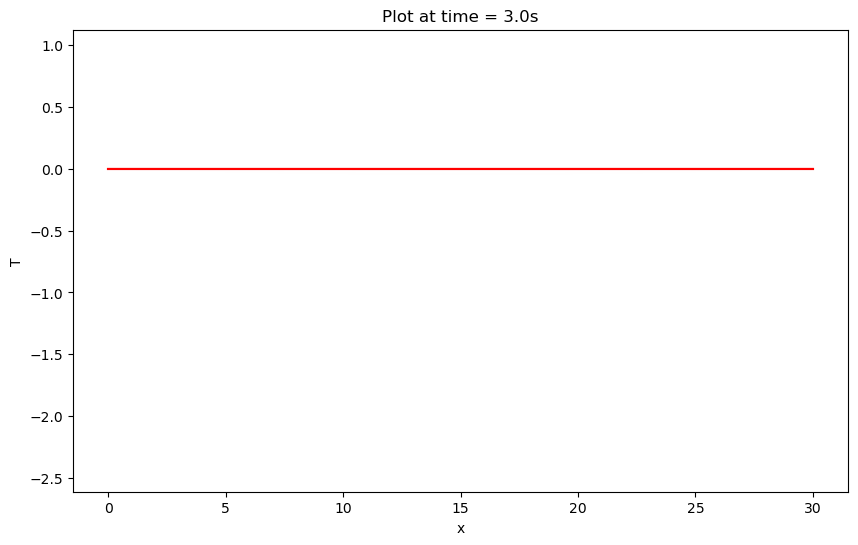

In [4]:
Te = h_e.heat_1d_explicit(f_u_0_x, D, dx, L, f_u_t_0, f_u_t_L, t_max, dt_mod=1)
h_e.heat_plotter(Te,t_max,10)

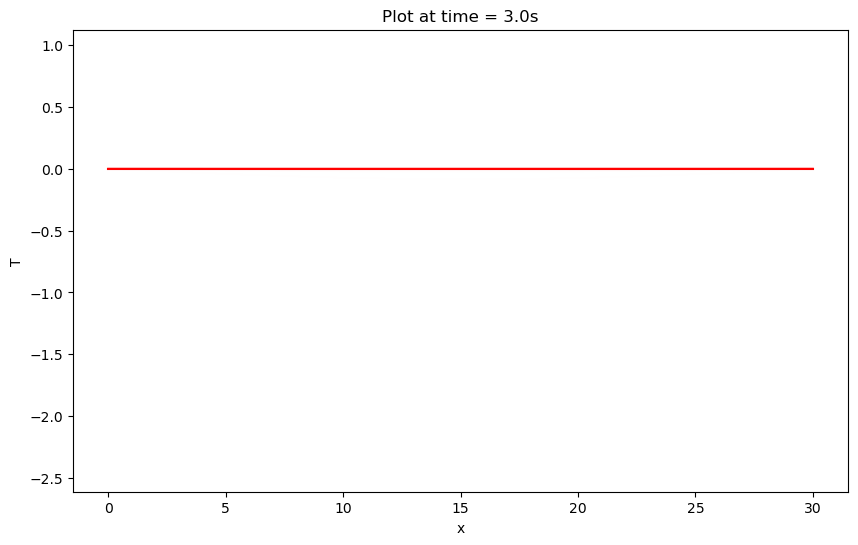

In [5]:
Ti = h_e.heat_1d_implicit(f_u_0_x, D, dx, dt, L, f_u_t_0, f_u_t_L, t_max)
h_e.heat_plotter(Ti,t_max,10)

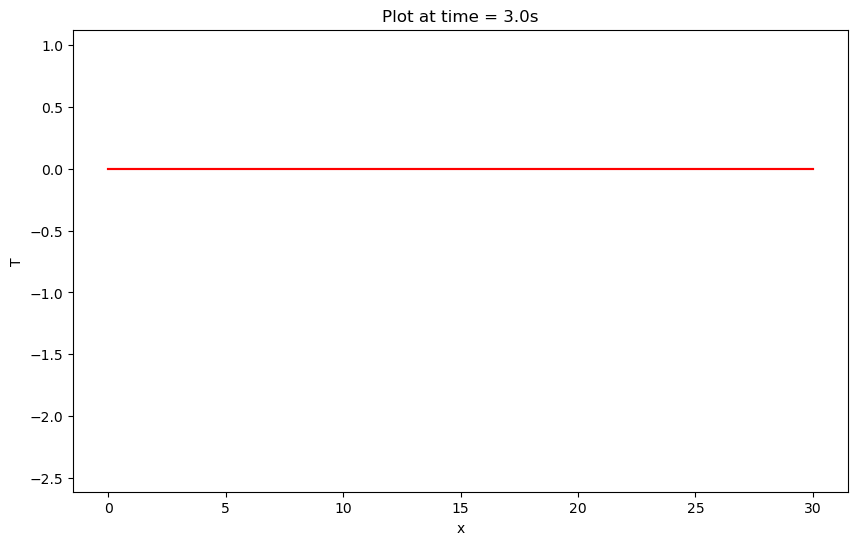

In [6]:
Tcr = h_e.crank_nicholson_1d(f_u_0_x, D, dx, dt, L, f_u_t_0, f_u_t_L, t_max)
h_e.heat_plotter(Tcr, t_max, 10)